# Video Game Sales Analysis

### Comparing sales between genres from 2000 to 2019

Video game are an increasingly popular pass-time. As technology has progressed, so too has the potential for games to create a fun and memorable experience. Titles are produced on all scales, from one-person projects to blockbuster-level endeavors. The market for games likewise benefits from burgeoning popularity. The demographics of gamers is wider than ever before. By analyzing which genres of games sell better, the following research aims to inform where publishers might focus their interest and assist developers in making their projects more marketable. 

In [1]:
# imports
import pandas as pd
import numpy as np
from scipy import stats
from statsmodels.graphics.gofplots import qqplot
from statsmodels.stats.multitest import multipletests
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from sklearn import preprocessing


%matplotlib inline
%reload_ext nb_black

<IPython.core.display.Javascript object>

In [2]:
def calc_non_param_ci(x1, x2, alpha=0.05):
    """Calc confidence interval for 2 group median test

    Process:
      * Find all pairwise diffs
      * Sort diffs
      * Find appropriate value of k
      * Choose lower bound from diffs as: diffs[k]
      * Choose upper bound from diffs as: diffs[-k]

    Based on: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2545906/

    :param x1: sample 1
    :param x2: sample 2
    :param alpha: significance level
    :return: (tuple) confidence interval bounds
    """
    x1 = np.array(x1)
    x2 = np.array(x2)

    n1 = x1.size
    n2 = x2.size
    cv = stats.norm.ppf(1 - alpha / 2)

    # Find pairwise differences for every datapoint in each group
    diffs = (x1[:, None] - x2).flatten()
    diffs.sort()

    # For an approximate (1-a)% confidence interval first calculate K:
    k = int(round(n1 * n2 / 2 - (cv * (n1 * n2 * (n1 + n2 + 1) / 12) ** 0.5)))

    # The Kth smallest to the Kth largest of the n x m differences
    # n1 and n2 should be > ~20
    ci_lo = diffs[k]
    ci_hi = diffs[-k]

    return ci_lo, ci_hi

<IPython.core.display.Javascript object>

In [3]:
def rbc_ind(x1, x2):
    """Calculate rank-biserial correlation coefficient

    Output values range from [0, 1]; interpret as:
      * Values closer to 0 are a weaker effect
      * Values closer to 1 are a stronger effect

    :param x1: sample 1
    :param x2: sample 2
    :return: (float) rank-biserial correlation coefficient
    """
    n1 = x1.size
    n2 = x2.size

    u, _ = stats.mannwhitneyu(x1, x2)
    rbc = 1 - (2 * u) / (n1 * n2)

    return rbc

<IPython.core.display.Javascript object>

In [4]:
def cles_ind(x1, x2):
    """Calc common language effect size

    Interpret as the probability that a score sampled
    at random from one distribution will be greater than
    a score sampled from some other distribution.

    Based on: http://psycnet.apa.org/doi/10.1037/0033-2909.111.2.361

    :param x1: sample 1
    :param x2: sample 2
    :return: (float) common language effect size
    """
    x1 = np.array(x1)
    x2 = np.array(x2)

    diff = x1[:, None] - x2
    cles = max((diff < 0).sum(), (diff > 0).sum()) / diff.size

    return cles

<IPython.core.display.Javascript object>

This data was scraped from [vgchartz.com](vgchartz.com) with a [BeautifulSoup script by GitHib user GregorUT](https://github.com/GregorUT/vgchartzScrape) and [hosted on Kaggle](https://www.kaggle.com/gregorut/videogamesales). 

The data is from 1985 to 2020 and includes categorical information including game title, year of release, platform released on, genre, and publisher. The fields for North American sales, European sales, Japanese sales, and global sales are used as response variables for the analysis.|

In [5]:
# load in the data
data_path = "data/vgsales.csv"
vg_sales = pd.read_csv(data_path)
vg_sales.head()

,Rank,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales
0,1,Wii Sports,Wii,2006.0,Sports,Nintendo,41.49,29.02,3.77,8.46,82.74
1,2,Super Mario Bros.,NES,1985.0,Platform,Nintendo,29.08,3.58,6.81,0.77,40.24
2,3,Mario Kart Wii,Wii,2008.0,Racing,Nintendo,15.85,12.88,3.79,3.31,35.82
3,4,Wii Sports Resort,Wii,2009.0,Sports,Nintendo,15.75,11.01,3.28,2.96,33.00
4,5,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,Nintendo,11.27,8.89,10.22,1.00,31.37


<IPython.core.display.Javascript object>

In [6]:
vg_sales.NA_Sales.describe()

count    16598.000000
mean         0.264667
std          0.816683
min          0.000000
25%          0.000000
50%          0.080000
75%          0.240000
max         41.490000
Name: NA_Sales, dtype: float64

<IPython.core.display.Javascript object>

The analysis will be only for games released after the year 2000. Sony's Playstation was released in 1994, and marked the introduction of larger, more detailed games made possible by the use of compact discs. Comparing sales from early in gaming history would not be reflective of the current climate. 

The data will be categorized by decade, and then the 2000's and 2010's will be selected. The data set only contains one entry for 2020, so it will also be dismissed.

In [7]:
# create 'decade' field for each game
eighties = list(range(1980, 1990))
nineties = list(range(1990, 2000))
oughts = list(range(2000, 2010))
tens = list(range(2010, 2020))
twenties = list(range(2020, 2030))

vg_sales["decade"] = "80s"
vg_sales.loc[vg_sales["Year"].isin(nineties), "decade"] = "90s"
vg_sales.loc[vg_sales["Year"].isin(oughts), "decade"] = "00s"
vg_sales.loc[vg_sales["Year"].isin(tens), "decade"] = "10s"
vg_sales.loc[vg_sales["Year"].isin(twenties), "decade"] = "20s"
print(vg_sales["decade"].value_counts())

# select 2000-2019
vg_00_10 = vg_sales[vg_sales["decade"] != "80s"]
vg_00_10 = vg_00_10[vg_00_10["decade"] != "20s"]
vg_00_10 = vg_00_10[vg_00_10["decade"] != "90s"]
vg_00_10.decade.value_counts()

00s    9208
10s    5144
90s    1769
80s     476
20s       1
Name: decade, dtype: int64


00s    9208
10s    5144
Name: decade, dtype: int64

<IPython.core.display.Javascript object>

This leaves 9,208 games for the 2000's and 5,144 for the 2010's. Check and handle null values.

In [8]:
vg_00_10.isna().sum()

Rank             0
Name             0
Platform         0
Year             0
Genre            0
Publisher       36
NA_Sales         0
EU_Sales         0
JP_Sales         0
Other_Sales      0
Global_Sales     0
decade           0
dtype: int64

<IPython.core.display.Javascript object>

The `publisher` field has some null values. This shouldn't affect the analysis based on genre, but these entries will be dropped to future proof subsequent analysis. Any title with `NA_Sales` of zero will dropped to preserve the integrity of the statistical tests. If another region's sales are analyzed, this will need to be redone accordingly.

In [9]:
# remove entries with zero 'NA_Sales'
vg_00_10 = vg_00_10[vg_00_10["NA_Sales"] > 0.08]
vg_00_10 = vg_00_10.dropna()
vg_00_10.decade.value_counts()

00s    4829
10s    2086
Name: decade, dtype: int64

<IPython.core.display.Javascript object>

With the desired years selected, the distributions of `Genre` can be compared.

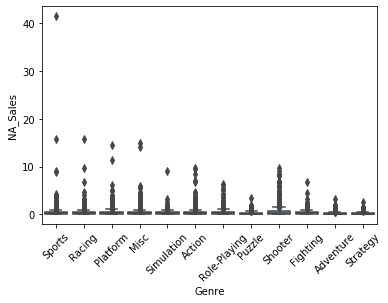

<IPython.core.display.Javascript object>

In [10]:
boxplots = sns.boxplot("Genre", "NA_Sales", data=vg_00_10)
boxplots.set_xticklabels(boxplots.get_xticklabels(), rotation=45)
plt.show()

There are two isses with these distributions. First, each genre is extremely skewed. This is expected as long-running franchises with name recognition are going to be selling better. Second, The sports genre has an outlier amongst outliers. With over 40 million units sold, this extreme outlier is Wii sports, with more than double the sales of the next closest game of any genre.

In [11]:
vg_00_10.head()

,Rank,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,decade
0,1,Wii Sports,Wii,2006.0,Sports,Nintendo,41.49,29.02,3.77,8.46,82.74,00s
2,3,Mario Kart Wii,Wii,2008.0,Racing,Nintendo,15.85,12.88,3.79,3.31,35.82,00s
3,4,Wii Sports Resort,Wii,2009.0,Sports,Nintendo,15.75,11.01,3.28,2.96,33.00,00s
6,7,New Super Mario Bros.,DS,2006.0,Platform,Nintendo,11.38,9.23,6.50,2.90,30.01,00s
7,8,Wii Play,Wii,2006.0,Misc,Nintendo,14.03,9.20,2.93,2.85,29.02,00s


<IPython.core.display.Javascript object>

Wii sports has an astronomically higher number of units sold compared to other games of it's era. It shipped with the Wii, inflating its sales, and focused on simplicity and accessibility. Since this research is meant to gain new insight, Wii sports will be discarded as [the lesson it teaches is already well learned](https://www.gamespot.com/articles/the-most-influential-games-of-the-21st-century-wii/1100-6466810/#:~:text=Like%20the%20Wii%2C%20it%20focused,the%20industry%20would%20approach%20accessibility).

In [12]:
# drop wii sports
# vg_sales = vg_sales[vg_sales["Name"] != "Wii Sports"]
vg_00_10 = vg_00_10[vg_00_10["Name"] != "Wii Sports"]
vg_00_10.head()

,Rank,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,decade
2,3,Mario Kart Wii,Wii,2008.0,Racing,Nintendo,15.85,12.88,3.79,3.31,35.82,00s
3,4,Wii Sports Resort,Wii,2009.0,Sports,Nintendo,15.75,11.01,3.28,2.96,33.00,00s
6,7,New Super Mario Bros.,DS,2006.0,Platform,Nintendo,11.38,9.23,6.50,2.90,30.01,00s
7,8,Wii Play,Wii,2006.0,Misc,Nintendo,14.03,9.20,2.93,2.85,29.02,00s
8,9,New Super Mario Bros. Wii,Wii,2009.0,Platform,Nintendo,14.59,7.06,4.70,2.26,28.62,00s


<IPython.core.display.Javascript object>

With Wii Sports discarded, the distributions are still heavily skewed, but are more comparable, especially between the more better selling genres.

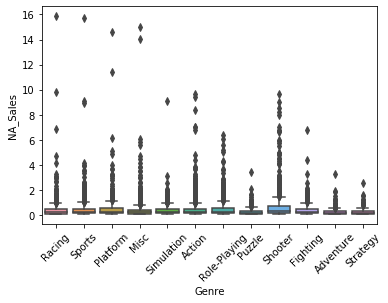

<IPython.core.display.Javascript object>

In [13]:
boxplots = sns.boxplot("Genre", "NA_Sales", data=vg_00_10)
boxplots.set_xticklabels(boxplots.get_xticklabels(), rotation=45)
plt.show()

These distributions are obviously skewed. By taking the natural log of `NA_Sales`, the meaning of ratios will be preserved while making the data  more visually palatable. Exponentiation after analysis will need to be done to describe the data in real terms.

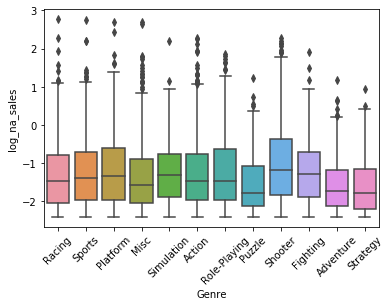

<IPython.core.display.Javascript object>

In [14]:
vg_00_10["log_na_sales"] = np.log(vg_00_10["NA_Sales"])
# pt = preprocessing.PowerTransformer(method="box-cox", standardize=False)
# vg_00_10["nrml_na_sales"] = pt.fit_transform(vg_00_10["NA_Sales"].values.reshape(1, -1))


boxplots = sns.boxplot("Genre", "log_na_sales", data=vg_00_10)
boxplots.set_xticklabels(boxplots.get_xticklabels(), rotation=45)
plt.show()

With this tranformation, the data is easier to visualize. The distributions now appear more normal, but visual inspection of boxplots is not sufficient to verify normality. QQ plots and a Shapiro tests can check normality. If all distributions are normal, a one-way ANOVA test will be the method of inquiry for determining if any of the mean sales by genre are significantly different. It is expected that these transformed distriubution will not be normal, as the logarithmic transformation preserves the ratios of the data. 

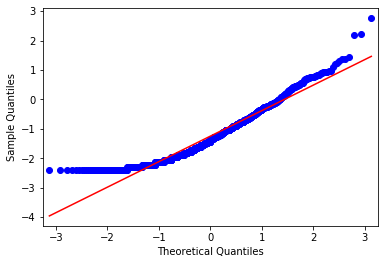

(0.9414966106414795, 8.118454594781188e-21)


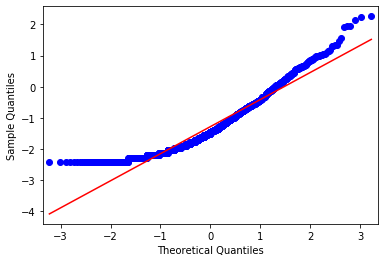

(0.9279647469520569, 4.5121965554587235e-27)


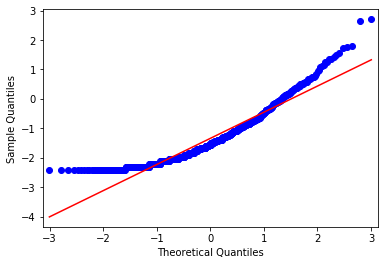

(0.9037695527076721, 2.4066492765835727e-21)


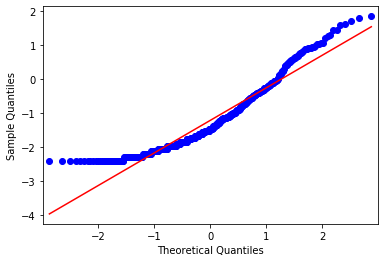

(0.9184775948524475, 9.717372670346963e-16)


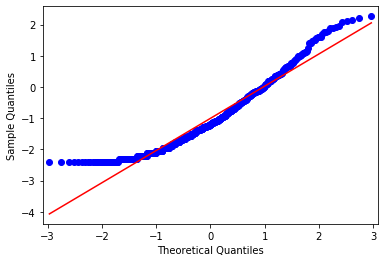

(0.9416412711143494, 1.6072313590087604e-15)


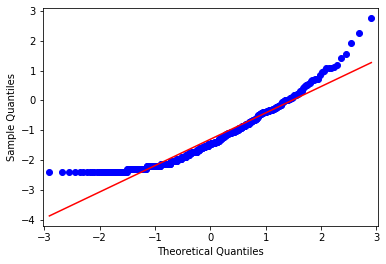

(0.9244439005851746, 5.368219004594306e-16)


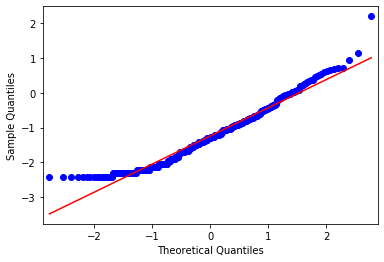

(0.9578321576118469, 1.2331667242904132e-08)


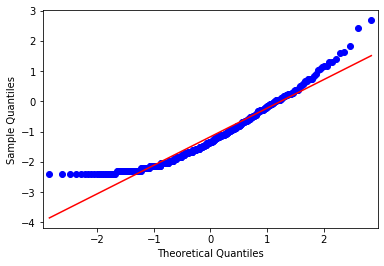

(0.935478925704956, 5.006460198665741e-13)


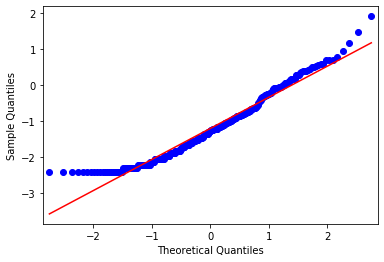

(0.9547686576843262, 1.3237593243786705e-08)


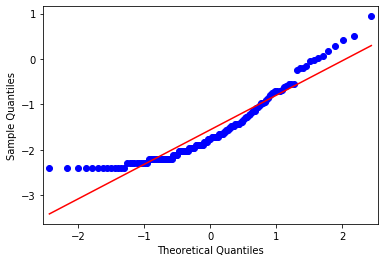

(0.8934146761894226, 2.205050897430283e-08)


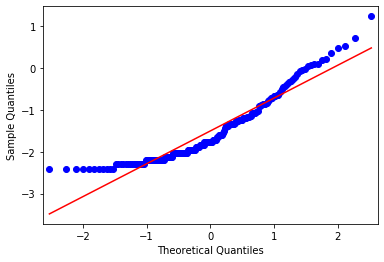

(0.8974376916885376, 1.2914871394542615e-09)


<IPython.core.display.Javascript object>

In [15]:
# separate based on genres.
sports = vg_00_10[vg_00_10["Genre"] == "Sports"]
action = vg_00_10[vg_00_10["Genre"] == "Action"]
misc = vg_00_10[vg_00_10["Genre"] == "Misc"]
rpg = vg_00_10[vg_00_10["Genre"] == "Role-Playing"]
adventure = vg_00_10[vg_00_10["Genre"] == "Adevnture"]
shooter = vg_00_10[vg_00_10["Genre"] == "Shooter"]
racing = vg_00_10[vg_00_10["Genre"] == "Racing"]
sim = vg_00_10[vg_00_10["Genre"] == "Simulation"]
platform = vg_00_10[vg_00_10["Genre"] == "Platform"]
fighting = vg_00_10[vg_00_10["Genre"] == "Fighting"]
strategy = vg_00_10[vg_00_10["Genre"] == "Strategy"]
puzzle = vg_00_10[vg_00_10["Genre"] == "Puzzle"]


# make a list of the genre data frames
genres = (
    sports,
    action,
    misc,
    rpg,
    # adventure,
    shooter,
    racing,
    sim,
    platform,
    fighting,
    strategy,
    puzzle,
)


# create a qq plot for each genre
for genre in genres:
    qqplot(genre["log_na_sales"], line="s")
    # plt.title(genre.Genre.)
    plt.show()
    print(stats.shapiro(genre["log_na_sales"]))

In [16]:
sports.describe()

,Rank,Year,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,log_na_sales
count,1142.000000,1142.000000,1142.000000,1142.000000,1142.000000,1142.000000,1142.000000,1142.000000
mean,4849.227671,2006.859895,0.460604,0.239370,0.029510,0.093599,0.822846,-1.244417
std,2908.428537,3.931444,0.769996,0.681393,0.192655,0.219366,1.630064,0.865556
min,4.000000,2000.000000,0.090000,0.000000,0.000000,0.000000,0.090000,-2.407946
25%,2427.000000,2003.000000,0.140000,0.010000,0.000000,0.010000,0.210000,-1.966113
50%,4595.500000,2007.000000,0.250000,0.070000,0.000000,0.030000,0.420000,-1.386294
75%,7314.750000,2010.000000,0.490000,0.200000,0.000000,0.080000,0.857500,-0.713350
max,10930.000000,2016.000000,15.750000,11.010000,3.600000,2.960000,33.000000,2.756840


<IPython.core.display.Javascript object>

As expected, the QQ plots and Shapiro tests confirm non-normality. Also, the selection by year seems to have yielded no results for `Adventure` games. `Adevnture` games will thus not be considered in the statistical testing. The implication of lack of adventure games in these years will be discussed in conclusions.

Since the distributions are not normal, a Kruskal Wallis test will be performed to determine if any of the median values are significantly different.

In [17]:
stats.kruskal(
    sports["log_na_sales"],
    action["log_na_sales"],
    misc['log_na_sales'],
    rpg["log_na_sales"],
    shooter["log_na_sales"],
    racing["log_na_sales"],
    sim["log_na_sales"],
    platform["log_na_sales"],
    fighting["log_na_sales"],
    strategy["log_na_sales"],
    puzzle["log_na_sales"],
)


KruskalResult(statistic=88.78031519033414, pvalue=9.34406651599953e-15)

<IPython.core.display.Javascript object>

Acorrding to the Kruskal test, at least one genre has a significantly different median than the others. Two suites of Mann-WhitneyU tests will be run. The first group will be for genres I expect to be similar. The second set will be for genres I expect to be different. All p-values will be corrected for multiple testing to account for the increasing type 1 error rate of running multiple tests.

In [18]:
# groups expected to be similar
_, p1 = stats.mannwhitneyu(sports["log_na_sales"], racing["log_na_sales"])
_, p2 = stats.mannwhitneyu(action["log_na_sales"], shooter["log_na_sales"])
_, p3 = stats.mannwhitneyu(strategy["log_na_sales"], puzzle["log_na_sales"])

# groups expected to be different
_, p4 = stats.mannwhitneyu(rpg["log_na_sales"], shooter["log_na_sales"])
_, p5 = stats.mannwhitneyu(fighting["log_na_sales"], platform["log_na_sales"])
_, p6 = stats.mannwhitneyu(action["log_na_sales"], strategy["log_na_sales"])

p_values = [p1, p2, p3, p4, p5, p6]
reject, corr_p, sidak, bonf = multipletests(p_values, alpha=0.05)
print(reject)
print(corr_p)
print(sidak)
print(bonf)

[False  True False  True False  True]
[1.37086129e-01 4.20255123e-08 4.37638681e-01 1.31323386e-03
 4.96550322e-01 3.50831755e-04]
0.008512444610847103
0.008333333333333333


<IPython.core.display.Javascript object>

From the pairwise analyses, there was a significant difference in median sales between sports and racing games; rpg and shooter games; and action and strategy games. Comparison of the histograms is for the transformed sales numbers, while effect sizes are in standard units. 

### Action x Shooter

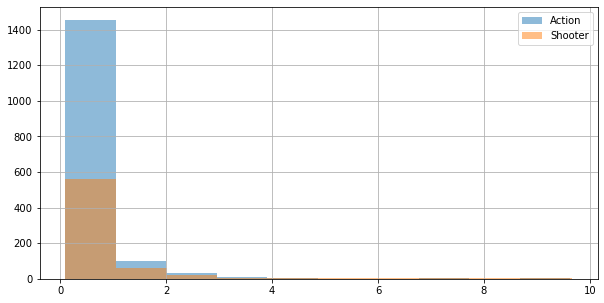

(-0.07, -0.03)
0.1509198584228485
0.5662590053287962


<IPython.core.display.Javascript object>

In [19]:
action["NA_Sales"].hist(alpha=0.5, label="Action", figsize=(10, 5))
shooter["NA_Sales"].hist(alpha=0.5, label="Shooter")
plt.legend()
plt.show()

print(calc_non_param_ci(action["NA_Sales"], shooter["NA_Sales"], alpha=0.05))
print(rbc_ind(action["NA_Sales"], shooter["NA_Sales"]))
print(cles_ind(action["NA_Sales"], shooter["NA_Sales"]))

### RPG x Shooter

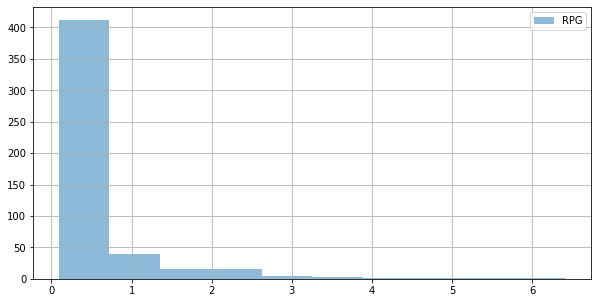

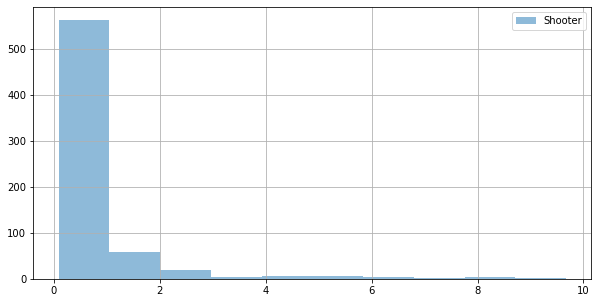

(-0.06000000000000001, -0.010000000000000009)
0.11657652059282231
0.5492806916461287


<IPython.core.display.Javascript object>

In [20]:
rpg["NA_Sales"].hist(alpha=0.5, label="RPG", figsize=(10, 5))
plt.legend()
plt.show()
shooter["NA_Sales"].hist(alpha=0.5, label="Shooter", figsize=(10, 5))
plt.legend()
plt.show()

print(calc_non_param_ci(rpg["NA_Sales"], shooter["NA_Sales"], alpha=0.05))
print(rbc_ind(rpg["NA_Sales"], shooter["NA_Sales"]))
print(cles_ind(rpg["NA_Sales"], shooter["NA_Sales"]))

### Action x Strategy

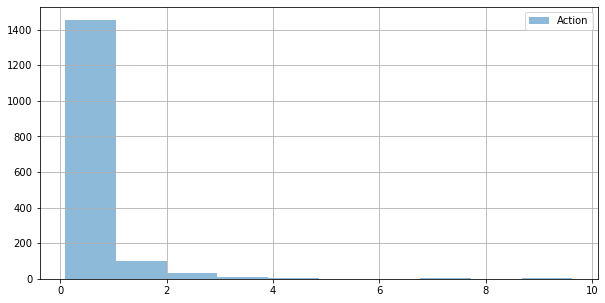

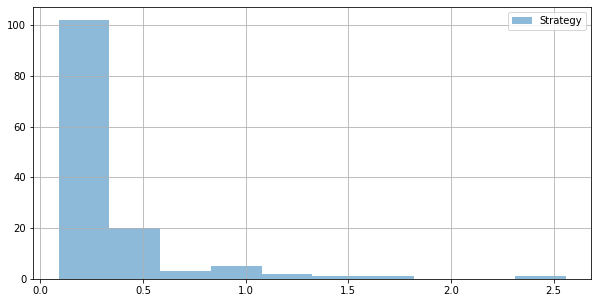

(0.01999999999999999, 0.06000000000000001)
0.19698062606926525
0.58421417672354


<IPython.core.display.Javascript object>

In [21]:
action["NA_Sales"].hist(alpha=0.5, label="Action", figsize=(10, 5))
plt.legend()
plt.show()
strategy["NA_Sales"].hist(alpha=0.5, label="Strategy", figsize=(10, 5))
plt.legend()
plt.show()

print(calc_non_param_ci(action["NA_Sales"], strategy["NA_Sales"], alpha=0.05))
print(rbc_ind(action["NA_Sales"], strategy["NA_Sales"]))
print(cles_ind(action["NA_Sales"], strategy["NA_Sales"]))


### Results and Conslusions

The distributions for the sales by genres were all heavily skewed, but at least one had a significantly different median than the others. The post hoc testing showed a significant difference between action and shooter games. It was expected that these two genres would sell similarly, since both have similar elements of high energy and violence. The difference may that shooters appeal to more competitve, skill based gamers, while action games appeal to people wanted a fast paced but character driven experience. Shooters outperformed action games. 

There were also significant differences in the medians for role-playing games compared to shooter games, and in the medians action games compared to strategy games. These differences were to be expected, since these two pairs compare a fast-paced violent genre to a slower, more intellectual genre. What was unexpected was there was no significant difference in the means of fighting and platform games. Since platforming games, like the Mario franchise, are less violent and competitve than fighting games like Mortal Combat, it was expected the fighting games would sell more, for same speculated reasons that shooters and action games outperformed the slower genres they were compared to. Upon further consideration, both platforming and fighting games focus on speed and knowledge of the levels (for platformers) or playable character (for fighting games). At the same time, both appeal to wide audiences as games with low barriers of entry. The Mario franchise is ubiqutious, and fighting games are easy to boot-up and start a match. 

The common language effect size for the three significantly different pairs compared were all about 0.55, meaning that a game chosen at random from one genre that sold better than other was not much better than chance. Genre likely does not have a large impact on well a game sells. 

### Limitations and Future Analysis

An important feature of this data is that most entries barely made the list for sales. The raw data had values of zero sales in North America up until the 50th percentile, where the value was 0.08 million units. This makes sense, as the barrier for entry into gaming is incredibly small. Any one with a little coding and art skills can make and publish a game. Likewise, most of the games made are going to reach a very small, incidental audience. The games that sold the best also benefit from name recognition, and the backing of large publishing studios. A future analysis focusing on independently published games would inform us about how smaller budget games sell while discounting unlovingly made cash-grab titles by bigger publishers. Similarly, the big-budget games can be analyzed on their own to see how to large titles compare to each other. The marketing budget for a game would correlate with the prominence of the publishing studio, and is an important feature to consider when the sale of any product is being analyzed.

Future analysis would also benefit from a greater variety of descriptive features. Features such as colorfulness, accessibility, speed of play, and length of game are just some examples that might influence someone's decision to purchase. These potential features may also better quanitfy why some games sold better while transcending the sometimes arbitrary idea of genre. 